#  Anomaly Detection
## Outlier Reduction for Linear Regression
In this session, we'll be fitting a `LinearRegression` model on the `boston` dataset included in `scikit-learn`.  




## Getting started - imports

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split

## Loading dataset

First order of business is to load in the dataset.  
Run the following cell to load the boston dataset and get a description of it.

In [2]:
# Load boston housing dataset
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Some preparatory processing.

In [3]:
# Select out just a few of the features 
# NOX      nitric oxides concentration (parts per 10 million)
# AGE      proportion of owner-occupied units built prior to 1
# RAD      index of accessibility to radial highways
# PTRATIO  pupil-teacher ratio by town
# LSTAT    % lower status of the population
boston_X = boston.data[:,(4,6,8,10,12)]
boston_y = boston.target
dataset = pd.DataFrame(np.column_stack([boston_X, boston_y])).sample(frac=1).reset_index(drop = True)

# Here's how to do the same with pandas
# boston_X = pd.DataFrame(boston.data[:,(4,6,8,10,12)])
# boston_y = pd.DataFrame(boston.target)
# dataset = pd.concat([boston_X, boston_y], axis=1, join_axes=[boston_X.index]).sample(frac=1).reset_index(drop = True)

dataset.columns = ['NOX', 'AGE', 'RAD', 'PTRATIO', 'LSTAT', 'TARGET']
dataset.describe()
dataset.head()

,NOX,AGE,RAD,PTRATIO,LSTAT,TARGET
0,0.413,21.9,4.0,22.0,8.05,18.2
1,0.435,29.7,4.0,17.0,5.99,24.5
2,0.389,31.9,1.0,15.3,8.23,22.0
3,0.538,100.0,4.0,21.0,19.88,14.5
4,0.624,98.8,4.0,21.2,15.39,18.0


#### Pull columns from dataset into variables X (everything except TARGET) and y (TARGET).

In [4]:
# Split into X and y sets (use indices 4,6,8,10,12 for X)

# Complete code below this comment  (Question #P4001)
# ----------------------------------

#>>> data.iloc[:,[0,3]]

X = np.array(dataset.iloc[:,[0,1,2,3,4]]) 
y = np.array(dataset.TARGET) 

# Print out some basic shape data on the arrays
print("X, y shape:", X.shape, y.shape)


X, y shape: (506, 5) (506,)


**Create training/validation split** with 30% data held out.

In [5]:
# Complete code below this comment  (Question #P4002)
# ----------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

# verify split shapes and contents
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (354, 5)
y_train.shape:  (354,)
X_test.shape:  (152, 5)
y_test.shape:  (152,)


Run cross validation on a linear ridge model.

In [6]:
naive_model = Ridge()

# Complete code below this comment  (Question #P4003)
# ----------------------------------
scores = cross_val_score(naive_model, X, y, cv=3)
print("Scores: ", scores)
print("Mean score (3 folds): ", np.mean(scores))

Scores:  [0.59195283 0.59934987 0.66944901]
Mean score (3 folds):  0.6202505716514846


Fit this model on the training dataset.

In [7]:
# Complete code below this comment  (Question #P4004)
# ----------------------------------
naive_model.fit(X_train, y_train)

Ridge()

Make some predictions from testing dataset and plot them.

(152, 5) (152,)


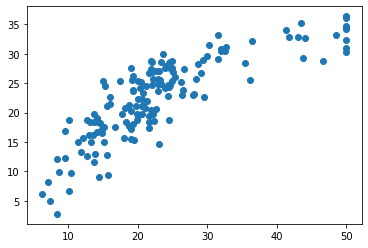

In [8]:
# Complete code below this comment  (Question #P4005)
# ----------------------------------
naive_predictions = naive_model.predict(X_test)
print(X_test.shape, naive_predictions.shape)
plt.scatter(y_test, naive_predictions)

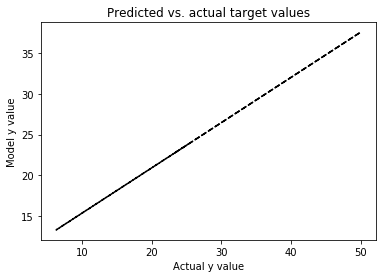

In [10]:
# Fit a trendline for visualization
z = np.polyfit(y_test, naive_predictions, 1)
p = np.poly1d(z)
plt.title("Predicted vs. actual target values")
plt.xlabel("Actual y value")
plt.ylabel("Model y value")
plt.plot(y_test, p(y_test), 'k--')

## Issues with the above model
It is worth noting that without outlier reduction / anomaly detection in the pipeline, 
performance is relatively low. 
The actual performance on the test set is only scarcely better than random guessing 
(we can assume a baseline performance of 50% in such a case, and the model scores about 70%).

## Why a trendline?
This is mainly for illustrative purposes. 
The highest-error estimations are those farthest from the trendline, and ideally, 
the line of best fit would be `f(x) = x` 
(that is, the estimate and actual values would be perfectly equal in all cases).

## What methods are available to us for outlier reduction?
We could try `KMeans` or an `EllipticEnvelope` again, but we're going to explore a few more options. 

In [11]:
from sklearn.ensemble import IsolationForest

# Construct IsolationForest 
iso_forest = IsolationForest(n_estimators=250,
                             bootstrap=True).fit(X, y)

In [12]:
help(IsolationForest)

Help on class IsolationForest in module sklearn.ensemble._iforest:

class IsolationForest(sklearn.base.OutlierMixin, sklearn.ensemble._bagging.BaseBagging)
 |  IsolationForest(*, n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False, n_jobs=None, behaviour='deprecated', random_state=None, verbose=0, warm_start=False)
 |  
 |  Isolation Forest Algorithm.
 |  
 |  Return the anomaly score of each sample using the IsolationForest algorithm
 |  
 |  The IsolationForest 'isolates' observations by randomly selecting a feature
 |  and then randomly selecting a split value between the maximum and minimum
 |  values of the selected feature.
 |  
 |  Since recursive partitioning can be represented by a tree structure, the
 |  number of splittings required to isolate a sample is equivalent to the path
 |  length from the root node to the terminating node.
 |  
 |  This path length, averaged over a forest of such random trees, is a
 |  measure of normality a

Carefully read through the API documentation for Isolation Forest!

Pull **inliers** into variables X_iso and y_iso.

In [13]:
# Get labels from classifier and be ready to cull outliers
iso_outliers = iso_forest.predict(X)==-1

# Complete code below this comment  (Question #P4006)
# ----------------------------------
X_iso = X[~iso_outliers]
y_iso = y[~iso_outliers]


[0.75268125 0.37348746 0.78611102 0.77674693 0.6482673 ]
Mean CV score w/ IsolationForest: 0.6674587944064543


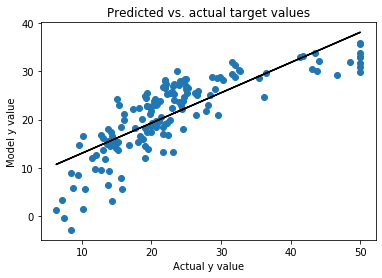

In [14]:
# We can of course run a train-test split on the separated data as well
X_train_iso, X_test_iso, y_train_iso, y_test_iso = train_test_split(X_iso, 
                                                                    y_iso, 
                                                                    test_size=0.3)
# Fit the new model using the IsolationForest training split
iso_model = Ridge()
iso_model.fit(X_train_iso, y_train_iso)

# Cross validate the new model
iso_scores = cross_val_score(estimator=iso_model, 
                             X=X_test_iso, y=y_test_iso)
print(iso_scores)
print("Mean CV score w/ IsolationForest:", np.mean(iso_scores))

iso_predictions = iso_model.predict(X_test)

# Plot the inlying points
plt.scatter(y_test, iso_predictions)

# Fit a trendline for visualization
z = np.polyfit(y_test, iso_predictions, 1)
p = np.poly1d(z)
plt.title("Predicted vs. actual target values")
plt.xlabel("Actual y value")
plt.ylabel("Model y value")
plt.plot(y_test, p(y_test), 'k-')

## Alternatives to IsolationForest: OneClassSVM
This means it's time to try something else.  
The code below will look very similar to the above, but using `OneClassSVM` in place of the `IsolationForest`:

In [15]:
from sklearn.svm import OneClassSVM

help(OneClassSVM)

Help on class OneClassSVM in module sklearn.svm._classes:

class OneClassSVM(sklearn.base.OutlierMixin, sklearn.svm._base.BaseLibSVM)
 |  OneClassSVM(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
 |  
 |  Unsupervised Outlier Detection.
 |  
 |  Estimate the support of a high-dimensional distribution.
 |  
 |  The implementation is based on libsvm.
 |  
 |  Read more in the :ref:`User Guide <outlier_detection>`.
 |  
 |  Parameters
 |  ----------
 |  kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
 |       Specifies the kernel type to be used in the algorithm.
 |       It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or
 |       a callable.
 |       If none is given, 'rbf' will be used. If a callable is given it is
 |       used to precompute the kernel matrix.
 |  
 |  degree : int, default=3
 |      Degree of the polynomial kernel function ('poly').
 | 

In [16]:
# Construct OneClassSVM (kernel='rbf') and fit to full dataset
svm = OneClassSVM(kernel='rbf').fit(X, y)

#### Mark outliers.
Pull **inliers** into variables X_svm and y_svm.

In [17]:
# Get labels from classifier and mark outliers
svm_outliers = svm.predict(X)==-1

# Pull inliers
X_svm = X[~svm_outliers]
y_svm = y[~svm_outliers]

[ 0.6777318   0.56115485  0.42797378  0.5970405  -0.45583226]
Mean CV score w/ OneClassSVM: 0.36161373358607474


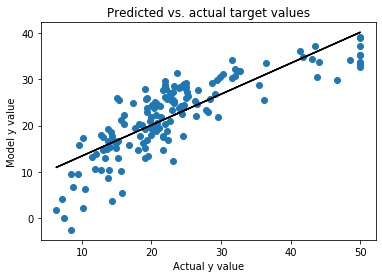

In [18]:
# Train-test split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=0.3)

svm_model = Ridge().fit(X_train_svm, y_train_svm)

# Cross validate the new model
iso_scores = cross_val_score(estimator=svm_model, 
                             X=X_test_svm, y=y_test_svm)
print(iso_scores)
print("Mean CV score w/ OneClassSVM:", np.mean(iso_scores))

# Make predictions with the fitted model
svm_predictions = svm_model.predict(X_test)

# Plot the inlying points
plt.scatter(y_test, svm_predictions)

# Fit a trendline for visualization
z = np.polyfit(y_test, svm_predictions, 1)
p = np.poly1d(z)
plt.title("Predicted vs. actual target values")
plt.xlabel("Actual y value")
plt.ylabel("Model y value")
plt.plot(y_test, p(y_test), 'k-')
plt.show()

## Summary Analysis

Of the anomaly detection algorithms used, 
which had the highest marginal performance? 
Consider computational cost, which ones seemd to run fast versus slow?

## Going further: performance analysis w/ `scikit` modules
Compute and display the following for the models produced by each anomaly detection method:
 1. Confusion Matrix
 1. Accuracy
 1. Precision
 1. $F_1$-Score

In [19]:

# ----------------------------------------
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# cut the variables based on quartiles 
naive_predictions_qcut = pd.qcut(naive_predictions, q=4, labels=False)
y_test_qcut = pd.qcut(y_test, 4, labels=False)

# compute confusion matrix and store in confmatrix
confmatrix = confusion_matrix(y_test_qcut, naive_predictions_qcut.astype('i4'))
print(confmatrix)

# model accuracy computed and stored in accuracy 
# TP + TN / (TP + TN + FP + FN)
accuracy = accuracy_score(y_test_qcut, naive_predictions_qcut)
print("accuracy: ", accuracy)

# precision calculated and stored in precision object 
# TP / (TP + FP)
precision = precision_score(y_test_qcut, naive_predictions_qcut, average='micro')
print("precision: ", precision)

# compute f1 score and stored in object f1
f1 = f1_score(y_test_qcut, naive_predictions_qcut.astype('i4'), average='micro')
print("f1 score: ", f1)


[[29  7  2  0]
 [ 8 21 10  1]
 [ 1  6 20  9]
 [ 0  4  6 28]]
accuracy:  0.6447368421052632
precision:  0.6447368421052632
f1 score:  0.6447368421052632


In [20]:
#  IsolationForest
# ----------------------------------------

# cut the variables based on quartiles 
iso_predictions_qcut = pd.qcut(iso_predictions, q=4, labels=False)
y_test_qcut = pd.qcut(y_test, 4, labels=False)

# compute confusion matrix and store in confmatrix
confmatrix = confusion_matrix(y_test_qcut, iso_predictions_qcut.astype('i4'))
print(confmatrix)

# model accuracy computed and stored in accuracy 
# TP + TN / (TP + TN + FP + FN)
accuracy = accuracy_score(y_test_qcut, iso_predictions_qcut)
print("accuracy: ", accuracy)

# precision calculated and stored in precision object 
# TP / (TP + FP)
precision = precision_score(y_test_qcut, iso_predictions_qcut, average='micro')
print("precision: ", precision)

# compute f1 score and stored in object f1
f1 = f1_score(y_test_qcut, iso_predictions_qcut.astype('i4'), average='micro')
print("f1 score: ", f1)

[[30  6  2  0]
 [ 7 22 11  0]
 [ 1  7 18 10]
 [ 0  3  7 28]]
accuracy:  0.6447368421052632
precision:  0.6447368421052632
f1 score:  0.6447368421052632


In [21]:
#  OneClassSVM
# ----------------------------------------

# cut the variables based on quartiles 
svm_predictions_qcut = pd.qcut(svm_predictions, q=4, labels=False)
y_test_qcut = pd.qcut(y_test, 4, labels=False)

# compute confusion matrix and store in confmatrix
confmatrix = confusion_matrix(y_test_qcut, svm_predictions_qcut.astype('i4'))
print(confmatrix)

# model accuracy computed and stored in accuracy 
# TP + TN / (TP + TN + FP + FN)
accuracy = accuracy_score(y_test_qcut, svm_predictions_qcut)
print("accuracy: ", accuracy)

# precision calculated and stored in precision object 
# TP / (TP + FP)
precision = precision_score(y_test_qcut, svm_predictions_qcut, average='micro')
print("precision: ", precision)

# compute f1 score and stored in object f1
f1 = f1_score(y_test_qcut, svm_predictions_qcut.astype('i4'), average='micro')
print("f1 score: ", f1)




[[29  7  2  0]
 [ 7 22 11  0]
 [ 2  5 19 10]
 [ 0  4  6 28]]
accuracy:  0.6447368421052632
precision:  0.6447368421052632
f1 score:  0.6447368421052632


# finished! 